# US Mobility Exploratory Analysis

Originally, the goal of this section was to measure, for each county in the United States, the lead or lag of a reduction in mobility relative to any increase in number of coronavirus cases. After examining the Descartes Labs mobility data in detail, it became clear that that dataset showed very few counties had reduced movement completely to zero. In addition, most counties began reducing mobility at approximately the same time.

Thus, the analysis was revised to identify common patterns of change in mobility. Following this, a correlation between change in mobility and change in infection rate was attempted to be observed.

To identify common patterns in mobility, the approach is to use the k-means clustering algorithm implemented in the sklearn Python library to cluster counties by the time series of the m50_index. The k-means algorithm iteratively changes the class membership of each county to the class of the closest centroid, which is recomputed at the end of each iteration. This sequence of operations is repeated until a maximum number of iterations is reached or a change index falls below a specified tolerance. For a given county, the m50_index on each day is treated as an individual feature and thus, a cluster's centroid is itself a sequence of m50_index's that can be interpreted as a time series. 

# Part 1: Identify Patterns in Change in Mobility

First, the Cluster_TS class, with several useful methods, is defined to aid in the analysis. The Cluster_TS stores the raw data and outputs from clustering the raw data in an object. Also, Cluster_TS has methods for clustering using the sklearn library's implementation of the k-menas algorithm and for visualizing the data. One is able to plot resulting cluster centroids and all associated members of a class from the raw data. 


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib notebook

from datetime import datetime

In [2]:
class Cluster_TS:
    
    def __init__(self, df, nclusters = 4):
        
        #initialize Cluster_TS object
        #error handling of arguments is not included
        #nclusters should be an integer > 0
        #df is the dataset dataframe, which should have each time series as a row with an appropriate index
        #columns should be the column names, in order of increasing time, of data in the series
        
        import pandas as pd
        import numpy as np
        from sklearn.cluster import KMeans
        import matplotlib.pyplot as plt
        %matplotlib notebook
        
        self.nclusters = nclusters
        
        self.columns = df.columns.tolist()
        self.columns.sort()
        self.df = df[self.columns]

        self.clusters_df = pd.DataFrame()
        self.classes_df = pd.DataFrame()
        self.class_data_df = pd.DataFrame()
        
    def cluster(self, nclusters = None, maxiter = 300, tol = 0.0001):
        
        
        #can change object's number of clusters here
        #nclusters should be an integer
        
        if nclusters != None:
            self.nclusters = nclusters
        
        #convert self.df into numpy array of right form and cluster using KMeans object
        
        nparray = self.df.to_numpy()
        
        #fit Kmeans clustering model
        kmeans = KMeans(n_clusters = self.nclusters, random_state = 0).fit(nparray)
        
        #save cluster centroids to a dataframe
        #pandas dataframe by default has indices from 0 to n-1, in line with the order of the 
        #centroid rows
        self.clusters_df = pd.DataFrame(data = kmeans.cluster_centers_, columns = self.columns)
        
        #save class memberships
        
        temp = pd.DataFrame(kmeans.predict(nparray), columns = ['class'])
        self.classes_df = temp.copy()
        
        #dataframe of counts and cumulative % of rows of each cluster
        
        temp['num'] = 1
        temp = temp.groupby('class').count().sort_values(by = 'num', ascending = False)
        temp['numcumsumdescpct'] = 0
        
        #calculate cumulative sum
        for i in range(temp.shape[0]):
            temp.iloc[i, 1] = temp.iloc[0:i+1, 0].sum()
        
        #scale cumulative sum by total to get fraction
        temp['numcumsumdescpct'] = temp['numcumsumdescpct']/temp['numcumsumdescpct'].max()
        
        self.class_data_df = temp
        
    def plot_top_centroids(self, start=0, end = 5, xtick_rotation = 0, 
                           xlabel = None, ylabel = None, title = None, legend = False):
        
        #plots top (end - start) time series. end is the last index+1
        
        plt.figure()
        for i in range(start, end):
            
            plt.plot(self.columns, self.clusters_df.loc[self.class_data_df.index.tolist()[i], :].to_numpy())
        
        plt.xticks(rotation = xtick_rotation)
            
        if xlabel is not None:
            plt.xlabel(xlabel)
                
        if ylabel is not None:
            plt.ylabel(ylabel)
                
        if title is not None:
            plt.title(title)
            
        if legend:
            labels = self.class_data_df.index.tolist()[start: end]
            plt.legend(labels)
            
    def plot_cluster(self, cluster_index, xtick_rotation = 0, alpha = 0.2,
                     xlabel = None, ylabel = None, title = None):
        
        plt.figure()
        
        plt.title(str(self.class_data_df.loc[cluster_index, 'num']) + ' members in Cluster ' + str(cluster_index))
        
        #plot cluster centroid
        plt.plot(self.columns, self.clusters_df.loc[cluster_index, self.columns].to_numpy(), c = 'r')
        
        plt.legend(['Cluster ' + str(cluster_index)])   
        
        #plot rows in cluster
        for i in range(self.classes_df.shape[0]):
            if self.classes_df.iloc[i]['class'] == cluster_index:
                plt.plot(self.columns, self.df[self.columns].iloc[i].to_numpy(), alpha = alpha, c = 'b')
                
        plt.plot(self.columns, self.clusters_df.loc[cluster_index, self.columns].to_numpy(), c = 'r')
        
        plt.xticks(rotation = xtick_rotation)
        
        if xlabel is not None:
            plt.xlabel(xlabel)
                
        if ylabel is not None:
            plt.ylabel(ylabel)
                
        if title is not None:
            plt.title(title)
            
         
         

First, the data mobility data is loaded. The loaded data is the previously cleaned, transposed data with the a column added for '2020-04-20', which was previously missing.

In [3]:
dl = pd.read_csv('dl-4-23-fa.csv').set_index('fips')
dl.head()

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-21,2020-04-22,2020-04-23,2020-04-20
fips,,,,,,,,,,,,,,,,,,,,,
1,79.0,98.0,100.0,96.0,104.0,123.0,107.0,80.0,103.0,103.0,...,51.0,56.0,59.0,68.0,49.0,4.0,62.0,62.0,47.0,0.0
1001,49.0,100.0,95.0,95.0,100.0,116.0,79.0,58.0,108.0,98.0,...,36.0,42.0,45.0,56.0,34.0,0.0,48.0,46.0,35.0,0.0
1003,81.0,100.0,95.0,90.0,102.0,114.0,95.0,82.0,96.0,99.0,...,49.0,52.0,53.0,57.0,43.0,16.0,58.0,59.0,36.0,0.0
1005,90.0,107.0,100.0,70.0,88.0,118.0,141.0,79.0,98.0,93.0,...,51.0,54.0,62.0,67.0,58.0,7.0,71.0,78.0,50.0,0.0
1007,53.0,95.0,100.0,94.0,111.0,133.0,112.0,51.0,124.0,100.0,...,51.0,50.0,55.0,55.0,45.0,4.0,59.0,53.0,35.0,0.0


Cluster_TS is used to identify whether any clusters of mobility i.e. mobility patterns exist in the mobility dataset. The workflow is to: 
1) Cluster the data for a selected number of clusters
2) Plot the centroids of clusters with the most members (generally to top 5 or 10 clusters) to observe how different the centroids are. This shows how different the clustered patterns are.
3) Plot members of individual clusters for some of the clusters with the most members to see how closely members of a class match a cluster's centroid

The number of clusters parameter was varied from 10 to 2000, with the variance of the intraclass variance decreasing as the numbers of clusters decreasing with increasing number of clusters. With an increasing number of clusters, more clusters consist of a single county. Nonetheless, some clusters based on the mobility after _ , when social isolation was mandated on a larger scale in the United States, did emerge. It can be seen the the clusters differ by the amount of reduction in mobility after _ ; some counties reduced movement more than others. Thus, it will be tested later whether the difference in reduction of mobility is correlated with a reduction in the infection growth rate.

In [46]:
#initialize and cluster mobility dataset
#10 clusters
dl_cluster = Cluster_TS(dl)
dl_cluster.cluster(10, maxiter = 1000, tol = 0.000001)

The clusters, sorted in descending order of the number of members 'num', is displayed. 'numcumsumdescpct' is the cumulative fraction of the total number of rows in the raw dataset for the rows above and including that row's cluster. For a given row, this gives an idea of how much of the dataset is included in the clusters for that row and all the previous rows. 

In [39]:
dl_cluster.class_data_df.head(10)

,num,numcumsumdescpct
class,,
8,1072,0.393973
3,813,0.692760
6,770,0.975744
0,59,0.997427
5,2,0.998162
1,1,0.998530
2,1,0.998897
4,1,0.999265
7,1,0.999632


The centroids of the top three clusters with the most members, which contains 97.6% of the counties are plotted. These plots are the m50_index plotted with respect to day. One can see that the m50_index histories start to differ significantly starting 2020-03-15 both during the weekends (valleys) and weekdays (crests). There appears to still be an increase in movement before the weekends. 

<IPython.core.display.Javascript object>


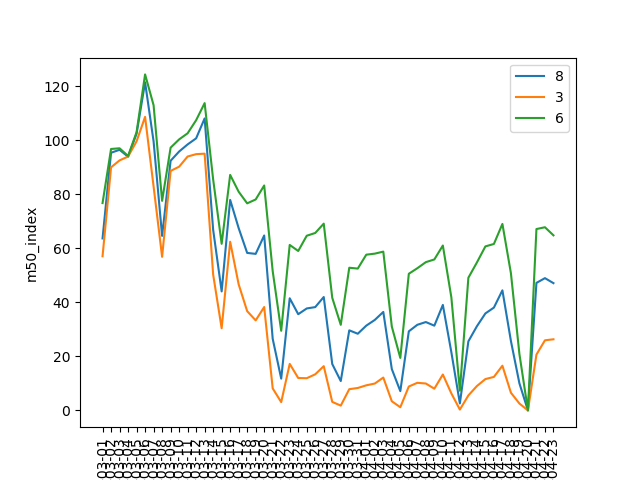

In [40]:
dl_cluster.plot_top_centroids(end = 3, xtick_rotation = 90, ylabel = 'm50_index', legend = True)


<IPython.core.display.Javascript object>


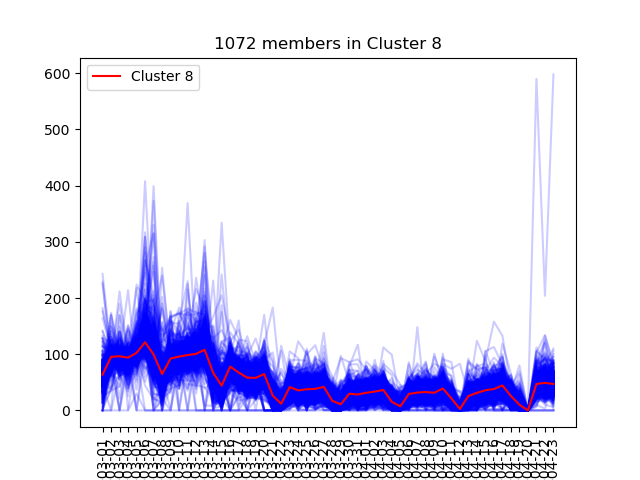

In [47]:
dl_cluster.plot_cluster(8, xtick_rotation = 90)

We now try clustering with 1000 clusters. To save memory we use the same Cluster_TS object and just recluster with 1000 clusters.

In [48]:
#initialize and cluster mobility dataset
#1000 clusters
dl_cluster.cluster(1000, maxiter = 1000, tol = 0.000001)
dl_cluster.class_data_df.head(10)

,num,numcumsumdescpct
class,,
31,48,0.017641
154,32,0.029401
606,28,0.039691
431,27,0.049614
401,27,0.059537
105,26,0.069092
34,23,0.077545
670,23,0.085998
886,22,0.094083


In [54]:
dl_cluster.class_data_df.tail(10)

,num,numcumsumdescpct
class,,
369,1,0.996692
370,1,0.997060
371,1,0.997427
372,1,0.997795
373,1,0.998162
374,1,0.998530
375,1,0.998897
377,1,0.999265
378,1,0.999632


<IPython.core.display.Javascript object>


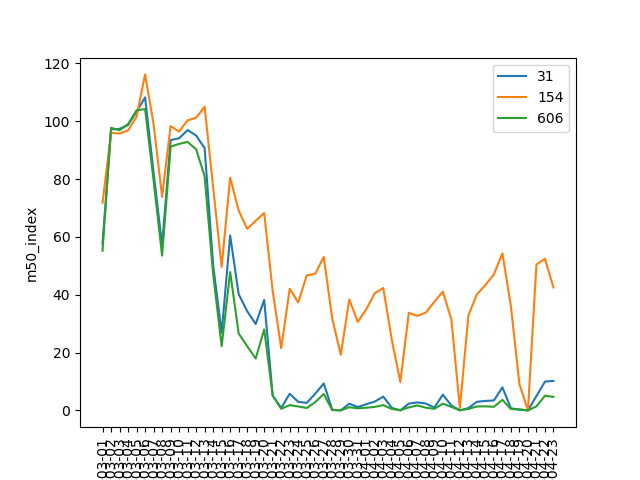

In [44]:
dl_cluster.plot_top_centroids(end = 3, xtick_rotation = 90, ylabel = 'm50_index', legend = True)

A cluster and its associated members are plotted. One can see a significant drop in movement starting on 2020-03-21 to less than 20% of the normal index.

<IPython.core.display.Javascript object>


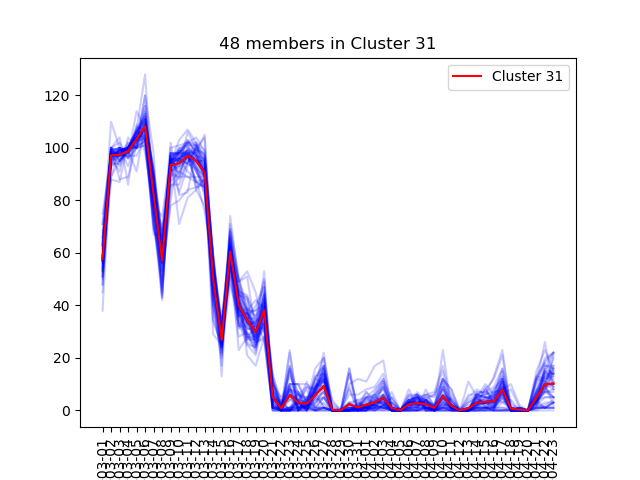

In [56]:
dl_cluster.plot_cluster(31, xtick_rotation = 90)

On the other hand, another cluster shows a decrease in movement to approximately 50% of the normal movement index during the weekdays following 2020-03-21.

<IPython.core.display.Javascript object>


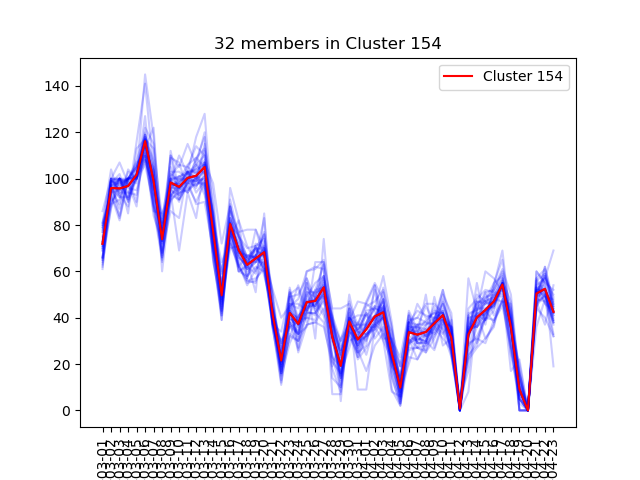

In [55]:
dl_cluster.plot_cluster(154, xtick_rotation = 90)

In [61]:
print('The number of clusters with only one member is {:d}'.format(dl_cluster.class_data_df.groupby('num').count().loc[1, 'numcumsumdescpct']))

The number of clusters with only one member is 800


One can plot some 'outliers' i.e. clusters with only one member.

<IPython.core.display.Javascript object>


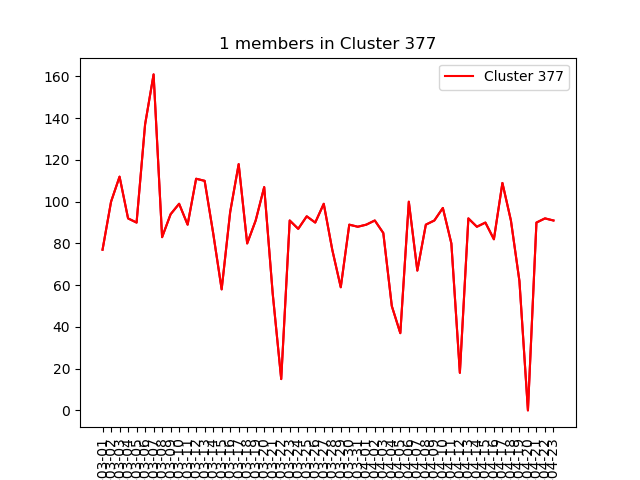

In [64]:
dl_cluster.plot_cluster(377, xtick_rotation = 90)

# Part 2: Determine Whether There is a Correlation Between Reduction in Mobility and Change in Infection Rate

Now that it has been shown that there is a range of changes in mobility, we will test the hypothesis that a reduction in mobility in a county results in a decrease in the growth rate of an infection. The growth rate of an infection is defined as the second derivative of the cumulative number of cases, which increases from day to day. Thus, we are looking to see whether the second derivative of the NYTimes cumulative case counts is negative following a period of reduced movement. Henceforth, the second derivative of the NYTimes cumulative case counts will be referred to as the acceleration of the infection count or infection acceleration.

The first derivative of the cumulative number of cases is the rate at which that total increases on a given day with units of cases/day. Thus, the second derivative, with units of cases/day^2, is the rate of change of the rate at which the case total changes. A positive second derivative means that the number of new cases increases from day to day, a negative second derivative means that the number of new cases decreases from day to day, and a second derivative of zero means the number of new cases stays the same from day to day. The second derivative of a time series is calculated using two nested applications of the numpy.gradient function. The following example shows a series, the first derivative, and second derivative. One can see that at index 8, where rate of increase of series starts to decrease, the second derivative is negative.

<IPython.core.display.Javascript object>


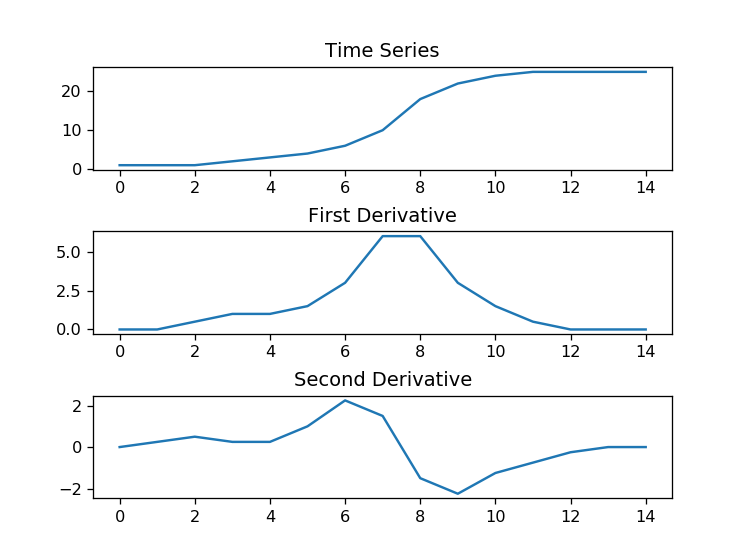

In [10]:
series = np.array([1, 1, 1, 2, 3, 4, 6, 10, 18, 22, 24, 25, 25, 25, 25])
fd = np.gradient(series)
sd = np.gradient(fd)
ind = range(len(series))

fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.plot(ind, series)
ax1.set_title('Time Series')
ax2.plot(ind, fd)
ax2.set_title('First Derivative')
ax3.plot(ind, sd)
ax3.set_title('Second Derivative')

plt.subplots_adjust(hspace = 0.6)

To look for a reduction in infection rate, the average infection acceleration for the two week periods from 3/15 through 3/28 and 4/10 through 4/23 are compared. The county-level average infection accelerations are plotted against the average county-level mobility indices for the two weeks prior to those windows because the coronavirus is known to have an incubation period of 14 days and thus any effect that movement has on the number of infections will be delayed. 

Several functions are defined to add in this analysis. moving_average() returns the moving average with a given window size of a time series and is applied to the NYTimes infection case data before the infection accelerations are calculated. This is necessary because the NYTimes data is not smooth due to revisions and updates that don't occur daily. This results in artificially high instantenous infection accelerations, which produces ariticially high and low average infection accelerations. A window of seven days is selected for the moving_average(). 

get_all_dates() returns a list of all calendar days between and including start and end days. The number of days in each month as used in get_all_dates() was verified against a 2020 calendar.

second_derivative() returns the second derivative, calculated at each index, of a series

compare_series_averages() plots a scatter plot of averages of two time series dataframes over two potentially different periods for intersecting indices

In [11]:
def moving_average(x, k):
    #calculates the moving average with window size of k for numpy array x
    #x is expected to be 2d
    #returns an array that is the same size as x
    #for simplicity, k must be odd
    #k must also be an integer though it is not checked here
    #the moving average is centered about the current element, that is
    #for the ith element in x, the ith element in the moving average array
    #is the average of the ith element and the floor(k/2) elements before and
    #at the ends of x, window elements outside of x are not included in the calculation
    
    
    try:
        nrows, ncols = x.shape
    except:
        x = x.reshape((1, -1))
    
    if (np.mod(k,2) == 0):
        raise Exception('Window size must be odd.')
    
    if (x.shape[1] == 0):
        raise Exception('Empty array.')
        
    if (k == 1):
        return x
    else:
        ma = np.zeros(x.shape)
        
        #floor of half of window size
        halfkf = int(np.floor(k/2))
        
        for i in range(x.shape[1]):

            if i < halfkf:
                ma[:, i] = np.average(x[:, 0:(i+halfkf+1)], axis = 1)
               
            elif i >= (x.shape[1] - halfkf):
                ma[:, i] = np.average(x[:, (i - halfkf):], axis = 1)
                
            else:
                ma[:, i] = np.average(x[:, (i-halfkf):(i+halfkf+1)], axis = 1)
            
        return ma



def get_all_dates(fd, ld):
    #returns list of all dates from firstdate fd to lastdate ld
    #fd and ld are strings in YYYY-MM-DD format
    
    monthlastday = {1: 31, 2: 29, 3: 31, 4: 30, 5: 31}
    
    fdmint = int(fd[5:7].lstrip('0'))
    ldmint = int(ld[5:7].lstrip('0'))
    
    monthlistint = list(range(fdmint, ldmint+1))
    
    datetimes = []
    
    for m in monthlistint:
        
        if m == fdmint:
            firstday = int(fd[8:10].lstrip('0'))
        else:
            firstday = 1
            
        if m == ldmint:
            lastday = int(ld[8:10].lstrip('0'))
        else:
            lastday = monthlastday[m]
        for d in range(firstday, lastday+1):

            datetimes.append('2020-' + datetime.strftime(datetime.strptime(str(m), '%m'), '%m') 
                           +'-' + datetime.strftime(datetime.strptime(str(d), '%d'), '%d') )
    
    return datetimes

def second_derivative(df, columns, k = 1):
    
    #k is the window size of the moving average applied to df
    #columns is the list of the desired columns in the output dateframe 
    
    smoothed_df = pd.DataFrame(moving_average(df[columns].to_numpy(), k), index = df.index, columns = columns)
    
    sd_df = pd.DataFrame(index= df.index, columns = columns)
    
    for i in range(df.shape[0]):
        
        sd_df.iloc[i, :] = pd.Series(np.gradient(np.gradient(smoothed_df.iloc[i].to_numpy())), index = columns)
        
    return sd_df

def compare_series_averages(x, y, xcolumns, ycolumns, 
                            xlabel = None, ylabel = None, title = None, 
                            xlim = None, ylim = None, ):
    
    #x and y are dataframes where elements of each row represent a time series
    #x and y should have the same index
    #columns is a list of columns whose elements will be row-wise averaged
    #for each common index, plots row averages of x and y
    
    cmp_index = x.index.intersection(y.index)
    
    cmp_df = pd.DataFrame(index = cmp_index, columns = ['x_avg', 'y_avg'])
    
    cmp_df['x_avg'] = x.loc[cmp_index, xcolumns].apply(lambda z: sum(z)/len(xcolumns), axis = 1)
    cmp_df['y_avg'] = y.loc[cmp_index, ycolumns].apply(lambda z: sum(z)/len(ycolumns), axis = 1)
    
    #plt.figure()
    
    cmp_df.plot.scatter('x_avg', 'y_avg', c = 'b', marker = '.', alpha = 0.2)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
    
    if title is not None:
        plt.title(title)
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if ylim is not None:
        plt.ylim(ylim)
        
    return cmp_df

We first load the cleaned NYTimes data and calculate the infection accelerations.

In [12]:
dates = get_all_dates('2020-03-01', '2020-04-23')

nytc = pd.read_csv('nyttransposedcases-4-26-fa.csv').set_index('fips')
nytc_sd = second_derivative(nytc, dates, k = 7)


We then select the period from 3/15 through 3/28 to examine the baseline infection accelerations. As discussed above, the period from 3/1 through 3/14 is considered for the baseline mobility as we expect the mobility from the prior two weeks to have an impact on the infection counts. From the plots above the mobility during this period is close to the normal mobility.

The average mobility and average infection acceleration is plotted for each county. The axis limits are set to exclude some outliers. One can see that most counties show a positive average infection acceleration i.e. most counties show in increasing rate of infection. In fact 2078/2554 counties show a positive average infection acceleration. Curiously, a relatively large number of counties, 484/2554, show average mobility indices that are greater than 100% of normal mobility. This is potentially because of a monthly or seasonal change in mobility patterns that is not captured by the normalizing constant, the median weekday distance traveled between 2/17 and 3/7 for a county, that Descartes Labs applied to generate m50_index values. 

<IPython.core.display.Javascript object>


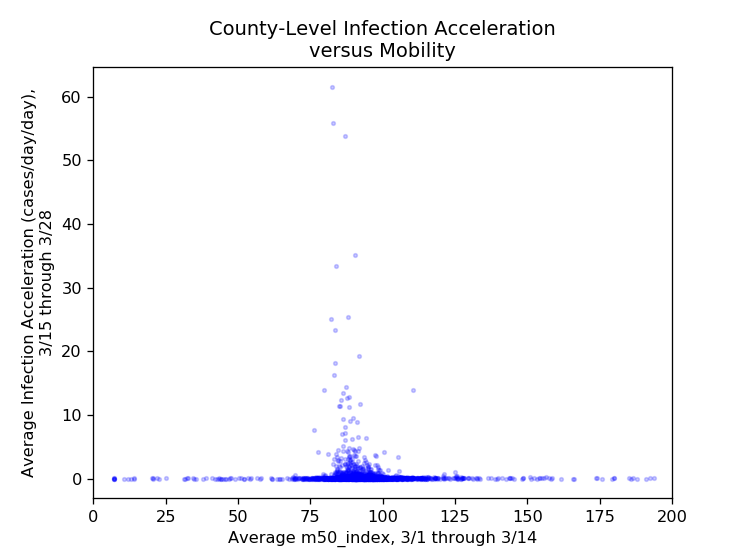

In [13]:
dldates = get_all_dates('2020-03-01', '2020-03-14')
nytcdates = get_all_dates('2020-03-15', '2020-03-28')

baseline_averages = compare_series_averages(dl, nytc_sd, dldates, nytcdates, xlabel = 'Average m50_index, 3/1 through 3/14',
                       ylabel = 'Average Infection Acceleration (cases/day/day),\n3/15 through 3/28',
                       xlim = (0.0, 200.0), title = 'County-Level Infection Acceleration\nversus Mobility')

In [14]:
print('There are {0:d}/{1:d} average infection accelerations'.format((baseline_averages['y_avg'] < 0).sum(), 
                                                                               baseline_averages.shape[0]) + 
      ' that are less than zero during the period of 3/15 through 3/28')
print('There are {0:d}/{1:d} average infection accelerations'.format((baseline_averages['y_avg'] == 0).sum(), 
                                                                               baseline_averages.shape[0]) + 
      ' that are equal to zero during the period of 3/15 through 3/28')
print('There are {0:d}/{1:d} average infection accelerations'.format((baseline_averages['y_avg'] > 0).sum(), 
                                                                               baseline_averages.shape[0]) + 
      ' that are greater than zero during the period of 3/15 through 3/28')
print('There are {0:d}/{1:d} average m50_index'.format((baseline_averages['x_avg'] > 100).sum(), 
                                                                               baseline_averages.shape[0]) + 
      ' that are greater than 100 during the period of 3/1 through 3/14')

There are 46/2554 average infection accelerations that are less than zero during the period of 3/15 through 3/28
There are 430/2554 average infection accelerations that are equal to zero during the period of 3/15 through 3/28
There are 2078/2554 average infection accelerations that are greater than zero during the period of 3/15 through 3/28
There are 484/2554 average m50_index that are greater than 100 during the period of 3/1 through 3/14


We now look at average infection accelerations for the period of 4/10 through 4/23, knowing that in the period from 3/25 through 4/9 there was a gross reduction in movement. One can see there are many counties, 1885/2554, that have average infection accelerations that are less than zero! Inspecting the plot, there amount of reduced mobility may also affect the magnitude of the reduction in infection rate as the most negative average infection accelerations occur at less than 10% average m50_index.

There do appear to still be some counties, 509/2554, with average infection accelerations that are greater than zero. It would be interesting to study these counties to understand why infection rates are still increasing in these counties. 

<IPython.core.display.Javascript object>


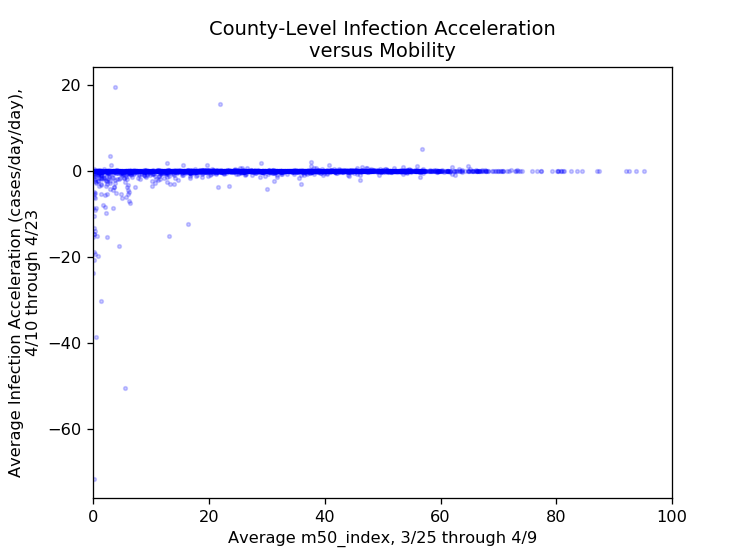

In [15]:
dldates = get_all_dates('2020-03-25', '2020-04-09')
nytcdates = get_all_dates('2020-04-10', '2020-04-23')

observed_averages = compare_series_averages(dl, nytc_sd, dldates, nytcdates, xlabel = 'Average m50_index, 3/25 through 4/9',
                       ylabel = 'Average Infection Acceleration (cases/day/day),\n4/10 through 4/23',
                        xlim = (0.0, 100.0), title = 'County-Level Infection Acceleration\nversus Mobility')

In [16]:
print('There are {0:d}/{1:d} average infection accelerations'.format((observed_averages['y_avg'] < 0).sum(), 
                                                                               observed_averages.shape[0]) + 
      ' that are less than zero during the period of 4/10 through 4/23')
print('There are {0:d}/{1:d} average infection accelerations'.format((observed_averages['y_avg'] == 0).sum(), 
                                                                               observed_averages.shape[0]) + 
      ' that are equal to zero during the period of 4/10 through 4/23')
print('There are {0:d}/{1:d} average infection accelerations'.format((observed_averages['y_avg'] > 0).sum(), 
                                                                               observed_averages.shape[0]) + 
      ' that are greater than zero during the period of 4/10 through 4/23')
print('There are {0:d}/{1:d} average m50_index'.format((observed_averages['x_avg'] > 100).sum(), 
                                                                               observed_averages.shape[0]) + 
      ' that are greater than 100 during the period of 3/25 through 4/9')

There are 1885/2554 average infection accelerations that are less than zero during the period of 4/10 through 4/23
There are 160/2554 average infection accelerations that are equal to zero during the period of 4/10 through 4/23
There are 509/2554 average infection accelerations that are greater than zero during the period of 4/10 through 4/23
There are 4/2554 average m50_index that are greater than 100 during the period of 3/25 through 4/9


We examine the m50_index, cases, and cases second derivate time series of the county with the most negative average second derivative of cases.

In [94]:
minsd_fips = observed_averages.loc[observed_averages['y_avg'] == observed_averages['y_avg'].min()].index.tolist()[0]
print('The fips of the county with the most negative average second derivative of cases is ' 
      + str(minsd_fips) + '. This is Nassau County.')

The fips of the county with the most negative average second derivative of cases is 36059. This is Nassau County.


In [91]:
minsd = pd.DataFrame(dl.loc[minsd_fips, dates])
minsd.columns = ['m50_index']
minsd = minsd.join(pd.DataFrame(nytc.loc[minsd_fips, dates]))
minsd.columns = ['m50_index', 'cases']
minsd = minsd.join(pd.DataFrame(nytc_sd.loc[minsd_fips, dates]))
minsd.columns = ['m50_index', 'cases', 'cases_sd']
minsd = minsd.reset_index()
minsd.columns = ['date', 'm50_index', 'cases', 'cases_sd']
minsd.sort_values('date', inplace = True)
minsd.head()

,date,m50_index,cases,cases_sd
0,2020-03-01,56.0,0,0.216667
1,2020-03-02,98.0,0,0.171429
2,2020-03-03,99.0,0,0.0833333
3,2020-03-04,100.0,0,0.514286
4,2020-03-05,103.0,1,0.994048


We plot cases and cases second derivative versus m50_index and see that after a two week period of almost zero mobility starting on 3/22, the infection rate levels off with a negative cases second derivative starting on 4/7.

<IPython.core.display.Javascript object>


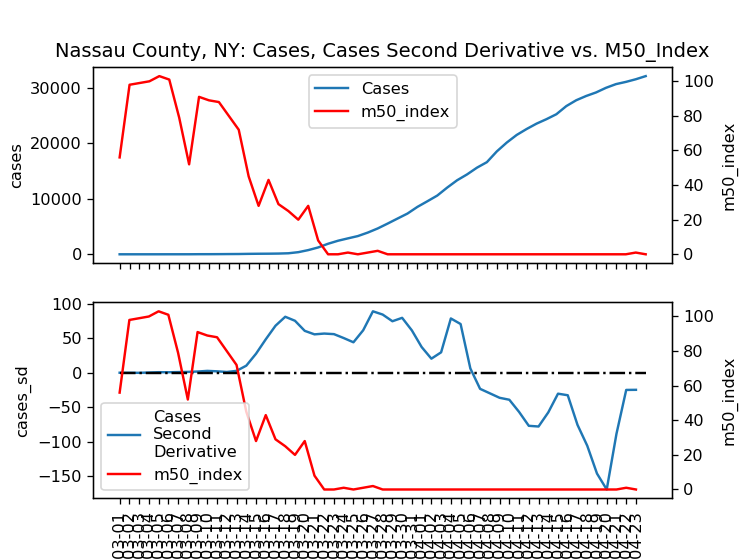

In [121]:
fig, (ax1, ax3) = plt.subplots(2,1)
#ax1.set_xlabel('date')
ax1.set_ylabel('cases')

ax1.plot(minsd['date'], minsd['cases'], '-', label = 'Cases')

plt.xticks(rotation = 90)

ax2 = ax1.twinx()
ax2.set_ylabel('m50_index')
ax2.plot(minsd['date'], minsd['m50_index'], '-r', label = 'm50_index')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'upper center')
ax1.set_xticklabels([])


ax3.set_xlabel('date')
ax3.set_ylabel('cases_sd')
ax3.plot(minsd['date'], minsd['cases_sd'], '-', label = 'Cases\nSecond\nDerivative')

ax4 = ax3.twinx()
ax4.set_ylabel('m50_index')
ax4.plot(minsd['date'], minsd['m50_index'], '-r', label = 'm50_index')
ax3.plot([0, minsd.shape[0]], [0, 0], '-.k')
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()

ax4.legend(lines3 + lines4, labels3 + labels4, loc = 'lower left')

ax1.set_title('Nassau County, NY: Cases, Cases Second Derivative vs. M50_Index')
plt.show()

Plotting the distributions of infection accelerations for the periods of 3/15 through 3/28 and 4/10 through 4/23 around the main mass of points shows a reduction in median average acceleration from 0.03 to -0.03. This corresponds to a reduction in median average m50_index from 93.0% to 28.4% in the prior two week periods. 

<IPython.core.display.Javascript object>


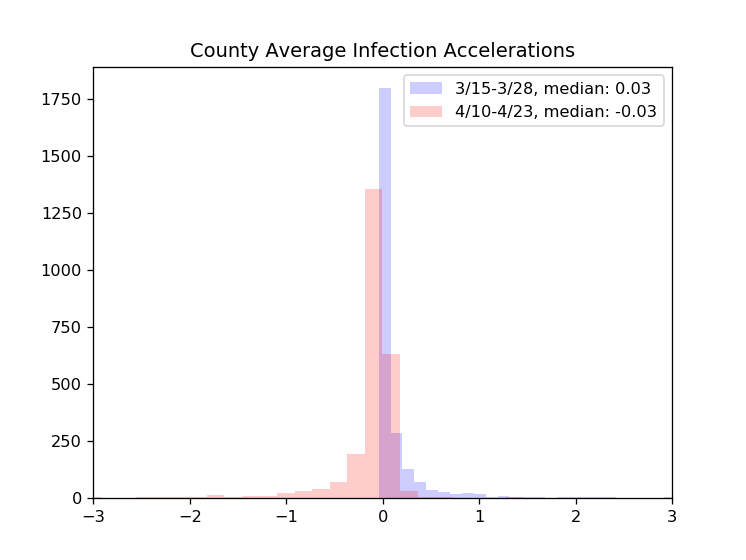

In [17]:
plt.figure()
plt.xlim((-3, 3))
_ = plt.hist(baseline_averages['y_avg'].to_numpy(), color = 'b', bins = 500, alpha = 0.2)
_ = plt.hist(observed_averages['y_avg'].to_numpy(), color = 'r', bins = 500, alpha = 0.2)

_ = plt.legend(['3/15-3/28, median: ' + '{:.2f}'.format(baseline_averages['y_avg'].median()), 
                '4/10-4/23, median: ' + '{:.2f}'.format(observed_averages['y_avg'].median())])
_ = plt.title('County Average Infection Accelerations')

<IPython.core.display.Javascript object>


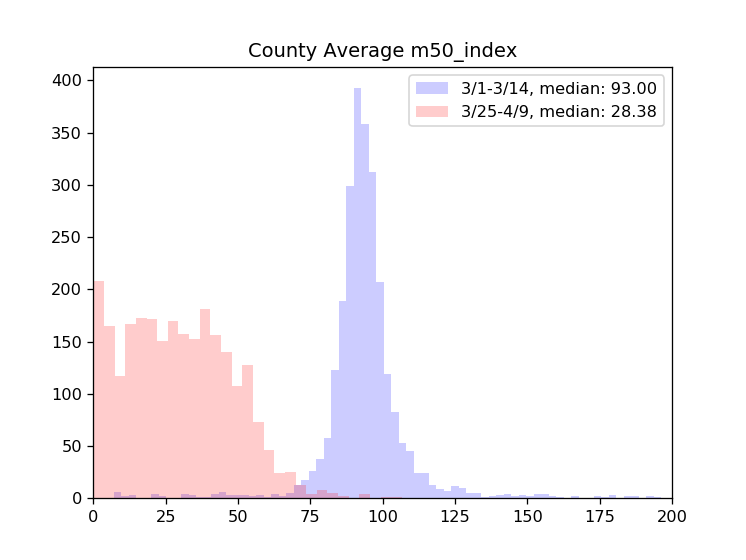

In [18]:
plt.figure()
plt.xlim((0, 200))
_ = plt.hist(baseline_averages['x_avg'].to_numpy(), color = 'b', bins = 500, alpha = 0.2)
_ = plt.hist(observed_averages['x_avg'].to_numpy(), color = 'r', bins = 100, alpha = 0.2)

_ = plt.legend(['3/1-3/14, median: ' + '{:.2f}'.format(baseline_averages['x_avg'].median()), 
                '3/25-4/9, median: ' + '{:.2f}'.format(observed_averages['x_avg'].median())])
_ = plt.title('County Average m50_index')

# Conclusion

Descartes Labs mobility index time series data and NYTimes cumulative infection count time series data were examined to determine whether there was a correlation between a reduction in mobility and a reduction in infection rate. The mobility index is taken as a proxy for the number of social interactions with a lower mobility index corresponding to fewer social interactions.

The enclosed exploratory analysis showed that different counties reduced mobility by different amounts starting in mid-March 2020. The change in infection rate was calculated as the second derivative of the NYTimes cumulative infection counts. Mobility and change in infection rates were averaged for two week periods.

A reduction in median average change in infection rate, from 0.03 cases/day/day from 3/15 through 3/28 to -0.03 cases/day/day from 4/10 through 4/23 was observed following a reduction in median mobility from 93% to 28.4% in the two-week periods prior to those two periods. This suggests that there may be a correlation between reduced mobility and reduced infection rate. The analysis revealed that the magnitude in reduction of mobility may also affect the magnitude of the reduction in the rate of infection. Of course, without accounting for other possible factors, we cannot say that there is a causal relationship between the reduction in mobility and infection rate but this is nonetheless an interesting observation.

Future work may involve accounting for other factors to assess the true impact of the reduction in mobility and investigating the counties of highest infection rate reduction.